**Medical Transcriptions Dataset Classification**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess

import string
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv("mtsamples.csv")

In [3]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [5]:
df = df[df["transcription"].notna()]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4966 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4966 non-null   int64 
 1   description        4966 non-null   object
 2   medical_specialty  4966 non-null   object
 3   sample_name        4966 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3898 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.6+ KB


In [7]:
categories = df.groupby(df["medical_specialty"])

In [8]:
i=1
for category_name, category in categories:
    print(f"Category {i}: {category_name}: {len(category)}")
    i = i+1

Category 1:  Allergy / Immunology: 7
Category 2:  Autopsy: 8
Category 3:  Bariatrics: 18
Category 4:  Cardiovascular / Pulmonary: 371
Category 5:  Chiropractic: 14
Category 6:  Consult - History and Phy.: 516
Category 7:  Cosmetic / Plastic Surgery: 27
Category 8:  Dentistry: 27
Category 9:  Dermatology: 29
Category 10:  Diets and Nutritions: 10
Category 11:  Discharge Summary: 108
Category 12:  ENT - Otolaryngology: 96
Category 13:  Emergency Room Reports: 75
Category 14:  Endocrinology: 19
Category 15:  Gastroenterology: 224
Category 16:  General Medicine: 259
Category 17:  Hematology - Oncology: 90
Category 18:  Hospice - Palliative Care: 6
Category 19:  IME-QME-Work Comp etc.: 16
Category 20:  Lab Medicine - Pathology: 8
Category 21:  Letters: 23
Category 22:  Nephrology: 81
Category 23:  Neurology: 223
Category 24:  Neurosurgery: 94
Category 25:  Obstetrics / Gynecology: 155
Category 26:  Office Notes: 50
Category 27:  Ophthalmology: 83
Category 28:  Orthopedic: 355
Category 29:  

In [9]:
df_filtered = categories.filter(lambda x: x.shape[0] > 10)

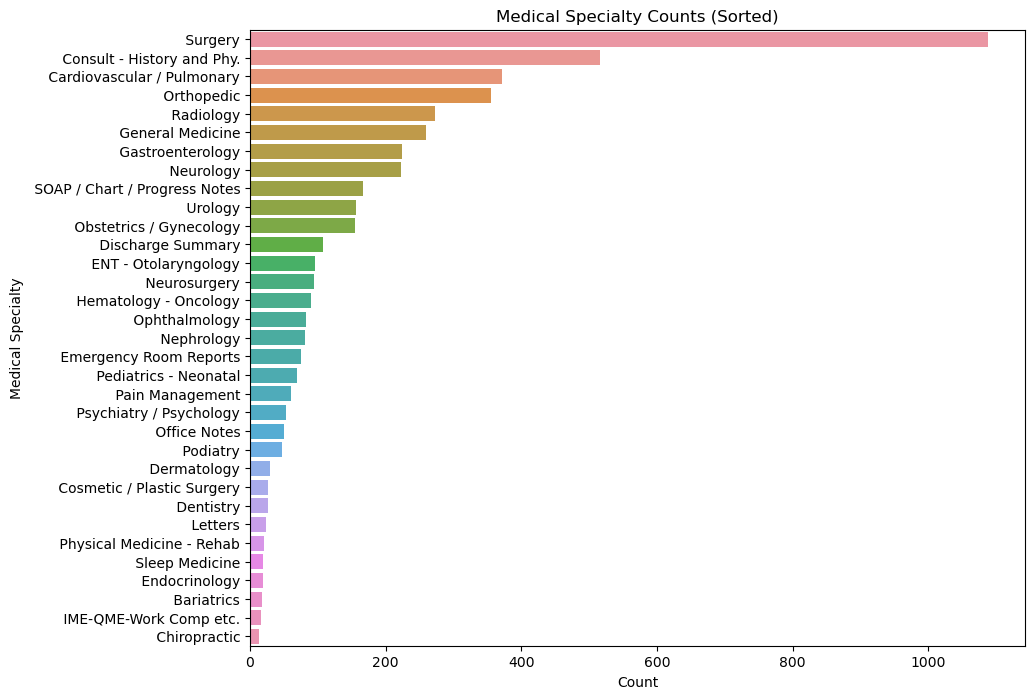

In [10]:
ordered_specialties = df_filtered['medical_specialty'].value_counts().index

plt.figure(figsize=(10, 8))
sns.countplot(y="medical_specialty", data=df_filtered, order=ordered_specialties)
plt.title("Medical Specialty Counts (Sorted)")
plt.xlabel("Count")
plt.ylabel("Medical Specialty")
plt.show()

In [11]:
df.isna().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

In [14]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    text = ' '.join(token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and token.is_alpha)
    return text

df['cleaned_transcription'] = df['transcription'].apply(clean_text)


In [15]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,cleaned_transcription
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",subjective old white female present complaint ...
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",past MEDICAL HISTORY difficulty climb stair di...
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",history present ILLNESS see ABC today pleasant...
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",M MODE leave atrial enlargement leave atrial d...
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",left ventricular cavity size wall thickness ap...


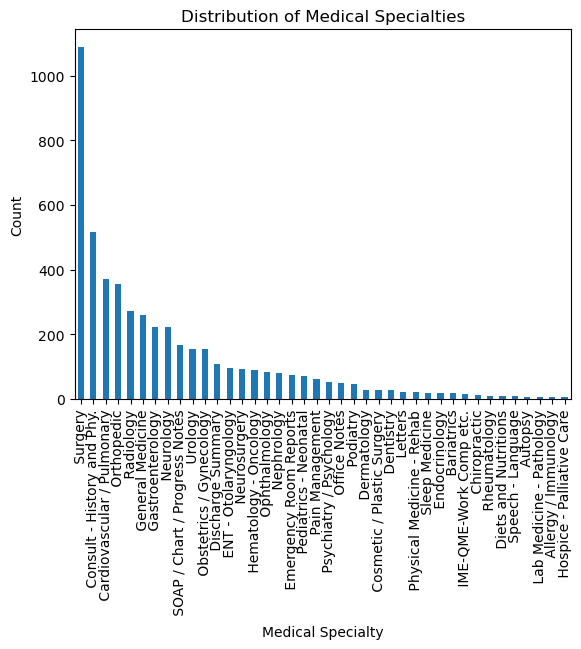

In [16]:
import matplotlib.pyplot as plt

df['medical_specialty'].value_counts().plot(kind='bar')
plt.title('Distribution of Medical Specialties')
plt.xlabel('Medical Specialty')
plt.ylabel('Count')
plt.show()


In [17]:
text_data = df['cleaned_transcription']

tfidf_vectorizer = TfidfVectorizer(max_features=1000)  
tfidf = tfidf_vectorizer.fit_transform(text_data)

tfidf_dense = tfidf.toarray()
labels = df['medical_specialty'].astype('category').cat.codes

tsne = TSNE(n_components=2, random_state=42, init='random',perplexity=30)
tsne_result = tsne.fit_transform(tfidf_dense)

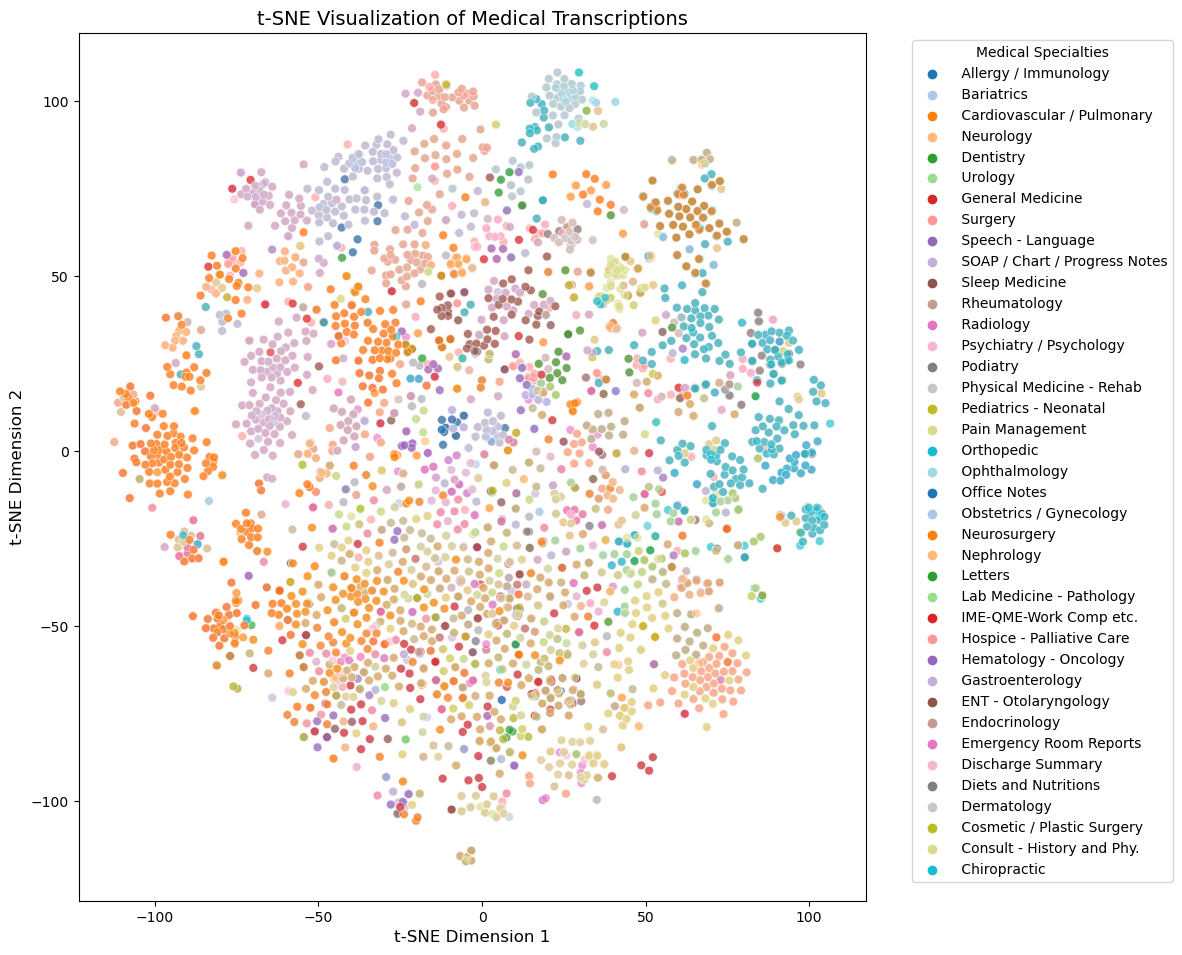

In [18]:
tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Medical Specialty'] = df['medical_specialty']  

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=tsne_df,
    x='Dimension 1',
    y='Dimension 2',
    hue='Medical Specialty',  
    palette='tab20', 
    alpha=0.65,
    s=40  
)

plt.title('t-SNE Visualization of Medical Transcriptions', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Medical Specialties', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10) 
plt.tight_layout()
plt.show()


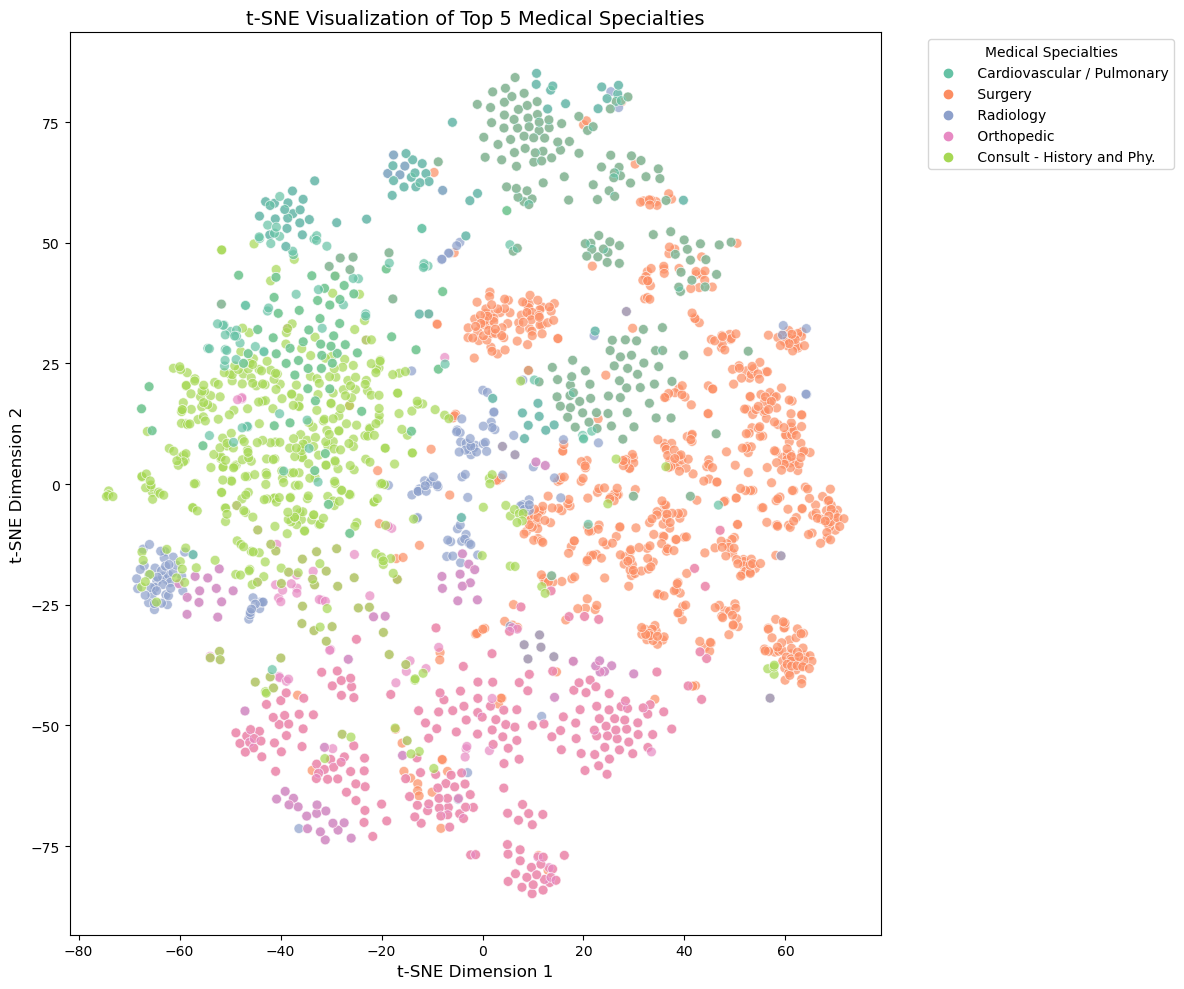

In [19]:
top_categories = df['medical_specialty'].value_counts().head(5).index

filtered_data = df[df['medical_specialty'].isin(top_categories)]

filtered_tfidf = tfidf_vectorizer.fit_transform(filtered_data['cleaned_transcription'])
filtered_tfidf_dense = filtered_tfidf.toarray()

tsne = TSNE(n_components=2, random_state=42, init='random', perplexity=30)
filtered_tsne_result = tsne.fit_transform(filtered_tfidf_dense)

filtered_tsne_df = pd.DataFrame(filtered_tsne_result, columns=['Dimension 1', 'Dimension 2'])
filtered_tsne_df['Medical Specialty'] = filtered_data['medical_specialty'].values

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=filtered_tsne_df,
    x='Dimension 1',
    y='Dimension 2',
    hue='Medical Specialty',
    palette='Set2',
    alpha=0.7,
    s=50
)

plt.title('t-SNE Visualization of Top 5 Medical Specialties', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Medical Specialties', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


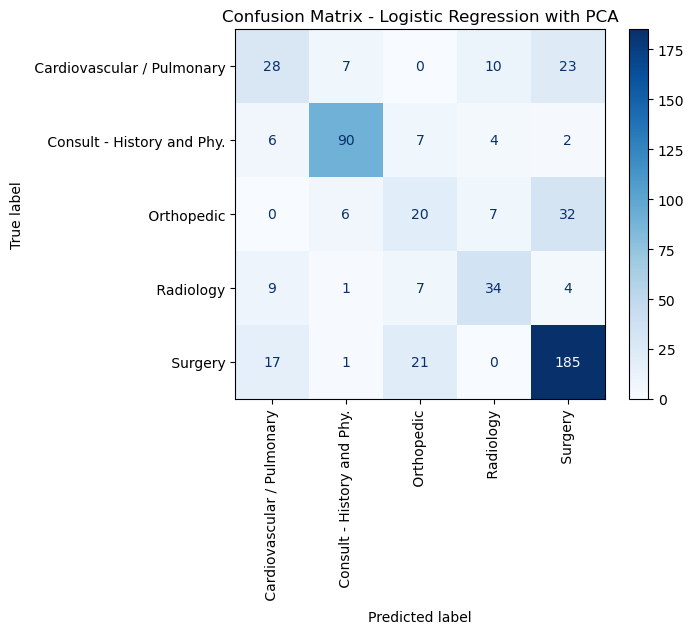

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.47      0.41      0.44        68
 Consult - History and Phy.       0.86      0.83      0.84       109
                 Orthopedic       0.36      0.31      0.33        65
                  Radiology       0.62      0.62      0.62        55
                    Surgery       0.75      0.83      0.79       224

                   accuracy                           0.69       521
                  macro avg       0.61      0.60      0.60       521
               weighted avg       0.67      0.69      0.68       521



In [20]:
top_categories = df['medical_specialty'].value_counts().head(5).index
df = df[df['medical_specialty'].isin(top_categories)]

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_transcription'])

pca = PCA(n_components=50, random_state=42)
pca_transformed = pca.fit_transform(tfidf_matrix.toarray())

labels = df['medical_specialty'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(pca_transformed, labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with PCA")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['medical_specialty'].astype('category').cat.categories))


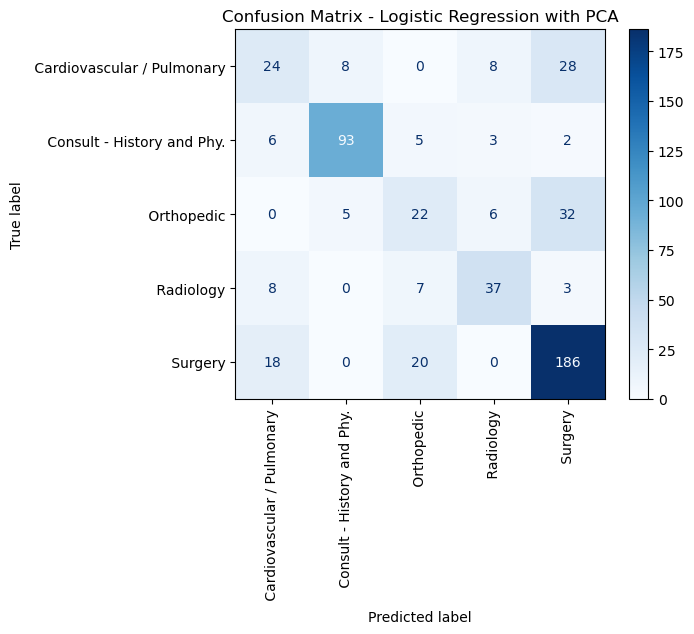

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.43      0.35      0.39        68
 Consult - History and Phy.       0.88      0.85      0.87       109
                 Orthopedic       0.41      0.34      0.37        65
                  Radiology       0.69      0.67      0.68        55
                    Surgery       0.74      0.83      0.78       224

                   accuracy                           0.69       521
                  macro avg       0.63      0.61      0.62       521
               weighted avg       0.68      0.69      0.69       521



In [21]:
top_categories = df['medical_specialty'].value_counts().head(5).index
df = df[df['medical_specialty'].isin(top_categories)]

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_transcription'])

pca = PCA(n_components=100, random_state=42)
pca_transformed = pca.fit_transform(tfidf_matrix.toarray())

labels = df['medical_specialty'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(pca_transformed, labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with PCA")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['medical_specialty'].astype('category').cat.categories))
